In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu2(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=181):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(1,3), stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear = nn.Linear(25, num_classes)
        self.adp_pool = nn.AdaptiveMaxPool2d((7, 25))
        #self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.dropout = nn.Dropout(0.9)
        self.dropout1 = nn.Dropout(0.8)
        self.relu = nn.ReLU(inplace=True)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.dropout(out)
        out = self.layer4(out)
        out = self.dropout1(out)
        out = self.adp_pool(out)
        out = self.linear(out)
        out = self.dropout1(out)
        out = self.flat(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [2, 3, 5, 2])

def ResNet101():
    return ResNet(BasicBlock, [3, 4, 23, 3])


if __name__ == "__main__":
    image = torch.rand(1, 3, 10, 100)
    model = ResNet34()
    print(model(image).size())


torch.Size([1, 1, 7, 181])


In [2]:
import scipy.io as sio
import numpy as np
import torch
import os
from os import listdir
from os.path import isfile, join
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import math
import pandas as pd
import cmath
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath

#from unet import UNet
# from auto import encoder, decoder

from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
#==========================================================================
# For Plotting loss graph
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

from functools import partial
from threading import Thread
from tornado import gen
# from AttRCNN_UNet import Att_R2U
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import sys
# from dataloader import norm
import csv
from sklearn.model_selection import train_test_split
from sys import getsizeof
# import wandb
# import logging
# logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import mat73

In [3]:
train_dataset_list = []
test_dataset_list = []

In [4]:
# df5  = mat73.loadmat("../datasets/400/DOA3/SNR_NS_40_3_400.mat")

In [5]:
df1  = sio.loadmat("../datasets/100/DOA7/SNR_NS_0_7_100000.mat")
df2  = sio.loadmat("../datasets/100/DOA7/SNR_NS_10_7_100000.mat")
df3  = sio.loadmat("../datasets/100/DOA7/SNR_NS_20_7_100000.mat")
df4  = sio.loadmat("../datasets/100/DOA7/SNR_NS_30_7_100000.mat")
df5  = sio.loadmat("../datasets/100/DOA7/SNR_NS_40_7_100000.mat")
df = [df1, df2, df3, df4, df5]

In [6]:
df1['NS_data'].shape

(8, 100, 100000)

In [7]:
new_train_dataset_list = []
new_test_dataset_list = []
train_dataset_list_label = []
test_dataset_list_label = []
def create_dataset(df):
    data = np.transpose(df['NS_data'], (2, 0, 1))
    label = df['DOA']
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.15, random_state=42)
    new_train_dataset_list.extend(X_train)
    new_test_dataset_list.append(X_test.tolist())
    train_dataset_list_label.extend(y_train)
    test_dataset_list_label.append(y_test.tolist())
    
for file in df:
    create_dataset(file)

In [8]:
del df
del df1
del df2
del df3
del df4
del df5

In [9]:
for idx, data in enumerate(new_train_dataset_list):
    new = np.zeros((3, 8, 100))
    for j in range(0, data.shape[0]):
        for k in range(0, data.shape[1]):
            new[0][j][k] = data[j][k].real
            new[1][j][k] = data[j][k].imag
            new[2][j][k] = cmath.phase(data[j][k])
    new_train_dataset_list[idx] = new
    
for idx, data in enumerate(new_test_dataset_list):
    for i, ndata in enumerate(data):
        new = np.zeros((3, 8, 100))
        for j in range(0, 8):
            for k in range(0, 100):
                new[0][j][k] = ndata[j][k].real
                new[1][j][k] = ndata[j][k].imag
                new[2][j][k] = cmath.phase(ndata[j][k])
        new_test_dataset_list[idx][i] = new

In [10]:
def get_data(train, test, batch_size, train_bool=True):
    class DOA_dataset(Dataset):
        def __init__(self, train, test):
            self.x = torch.from_numpy(np.array(train))
            self.y = torch.from_numpy(np.asarray(test))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample

    dataset = DOA_dataset(train, test)

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_bool)
    return loader


In [11]:
doa2_train_loader = get_data(new_train_dataset_list, train_dataset_list_label, 64, True)

In [12]:
del new_train_dataset_list
del train_dataset_list_label

In [13]:
test_dataset_list = []
for idx, data in enumerate(new_test_dataset_list):
    print(type(data))
    f = get_data(data, test_dataset_list_label[idx], 128, False)
    test_dataset_list.append(f)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [14]:
del new_test_dataset_list
del new

In [15]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [16]:
num_epochs = 40

weights_dir = "../doa_weights"

autoencoder = ResNet34()
cross_criterion = nn.CrossEntropyLoss()
focal_criterion = FocalLoss()
# if ('{}_DOA_{}_{}_model.pth'.format(nq_type, no_doa, no_samples) in [f for f in listdir(weights_dir) if isfile(join(weights_dir, f))]):
#     print("Pre-trained available for DOA_{}_{}_model.pth".format(no_doa, no_samples))
#     autoencoder = torch.load(os.path.join(weights_dir, '{}_DOA_{}_{}_model.pth'.format(nq_type, no_doa, no_samples)))

# model = nn.Sequential( pre_trained, autoencoder)
# model = ConvAutoencoder()
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    classification_model = autoencoder.cuda()
    optimizer = optim.AdamW(classification_model.parameters(), lr=0.0001, weight_decay=1e-5)
  
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=0.05, patience=3, verbose=True)

GeForce GTX 1080 Ti


In [17]:
acc_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
loss_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
mae_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}

In [31]:
nq_type = "NS" # Sub-Nyquist or Nyquist sample
no_samples = 100
no_doa = 7
weights_dir = "./doa_weights"

In [25]:
doa_train_loader = doa2_train_loader

In [32]:
%%time
# print(no_doa)
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        criterion = None
        if (i+1)>=25 :
          print("Criterion is changed to focal loss")
          criterion = focal_criterion.cuda()
        else:
          criterion = cross_criterion.cuda()
        for j,(features, labels) in enumerate(doa_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, no_doa))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.mean(torch.abs(pred.float().cuda() - labels.float()))

        loss_res['training'].append(training_loss/len(doa_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))
        mae_res['training'].append(training_mae/(len(doa_train_loader)*181))
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Training MAE: {}'
                      .format(i+1, num_epochs, training_loss/len(doa_train_loader), (100*(train_correct/train_total)), training_mae/(len(doa_train_loader)*181)))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        zero_val = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, no_doa))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.mean(torch.abs(pred.float().cuda() - labels.float()))

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                
                mae_res[10*val_data].append(validation_mae/(len(test_dataset_list[val_data])*181))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/(len(test_dataset_list[val_data])*181)))

                total_valdation_loss+=validation_loss

        scheduler.step(loss_res[0][len(loss_res[0])-1])
        # print("Odb Loss => ", loss_res[0][len(loss_res[0])-1])
        # print("Lr -> ", optimizer.state_dict()["param_groups"][0]['lr'])
        torch.save( classification_model, weights_dir+ "/{}_DOA_{}_{}_model.pth".format(nq_type, no_doa, no_samples))
        if best_valid_loss > total_valdation_loss:
            best_valid_loss = total_valdation_loss 
            # Saving Best Pre-Trained Model as .pth file
            torch.save( classification_model, weights_dir+ "/{}_DOA_{}_{}_best_model.pth".format(nq_type, no_doa, no_samples))
#         if i%10 == 0:
#           ddf = pd.DataFrame(acc_res)
#           ddf.to_csv(weights_dir+"res_DOA_{}_model.csv".format(doa))
        print("\n")

train()
print("Training Complete")


Training Starts !!!!!!!
Epoch [1/40], Training Loss: 3.8455, Training Accuracy: 5.2238, Training MAE: 0.09782654792070389
SNR [0dB], Validation Loss: 4.7962, Validation Accuracy: 2.1629, Validation MAE: 0.20873211324214935
SNR [10dB], Validation Loss: 4.3952, Validation Accuracy: 3.9038, Validation MAE: 0.1503583788871765
SNR [20dB], Validation Loss: 4.2755, Validation Accuracy: 4.4943, Validation MAE: 0.13312004506587982
SNR [30dB], Validation Loss: 4.2602, Validation Accuracy: 4.5229, Validation MAE: 0.13075751066207886
SNR [40dB], Validation Loss: 4.2610, Validation Accuracy: 4.4629, Validation MAE: 0.13139140605926514


Epoch [2/40], Training Loss: 3.6189, Training Accuracy: 6.5729, Training MAE: 0.08062172681093216
SNR [0dB], Validation Loss: 4.8251, Validation Accuracy: 2.0552, Validation MAE: 0.22196358442306519
SNR [10dB], Validation Loss: 4.3162, Validation Accuracy: 4.1810, Validation MAE: 0.16159787774085999
SNR [20dB], Validation Loss: 4.1552, Validation Accuracy: 4.8990, V

KeyboardInterrupt: 

In [29]:
max(acc_res[0]), max(acc_res[10]), max(acc_res[20]), max(acc_res[30]), max(acc_res[40])

(71.52666666666667, 92.2, 97.61999999999999, 99.0, 99.18)

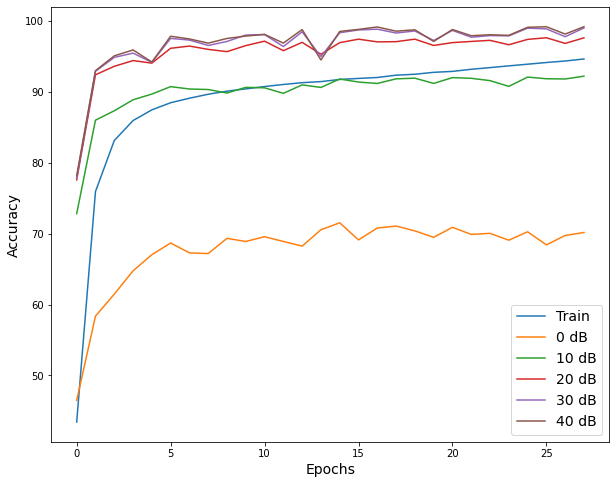

In [32]:
import matplotlib.pyplot as plt
ep = range(0, 28)
plt.figure(figsize=(10, 8))
plt.plot(ep, acc_res["training"], label='Train')
plt.plot(ep, acc_res[0], label='0 dB')
plt.plot(ep, acc_res[10], label='10 dB')
plt.plot(ep, acc_res[20], label='20 dB')
plt.plot(ep, acc_res[30], label='30 dB')
plt.plot(ep, acc_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.savefig("DOA3_resnet34")
plt.show()

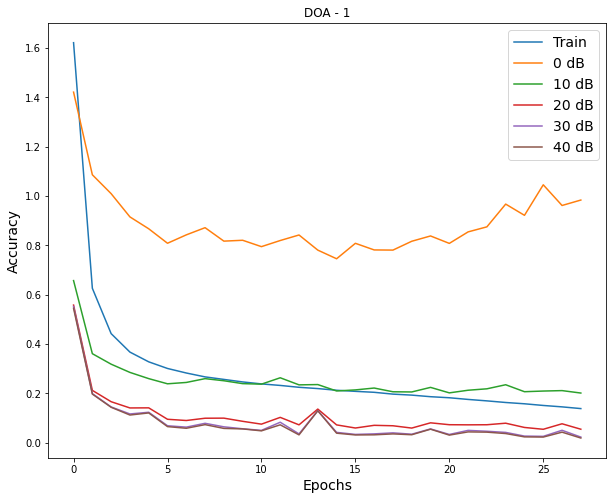

In [33]:
import matplotlib.pyplot as plt
ep = range(0, 28)
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title("DOA - 1")
plt.legend(fontsize=14)
plt.savefig("DOA3_resnet34")
plt.show()

# SNS DOA - 1

In [3]:
train_dataset_list = []
test_dataset_list = []

In [4]:
df1  = sio.loadmat("../SNS_dataset/DOA1/SNR_SNS_00_1.mat")
df2  = sio.loadmat("../SNS_dataset/DOA1/SNR_SNS_10_1.mat")
df3  = sio.loadmat("../SNS_dataset/DOA1/SNR_SNS_20_1.mat")
df4  = sio.loadmat("../SNS_dataset/DOA1/SNR_SNS_30_1.mat")
df5  = sio.loadmat("../SNS_dataset/DOA1/SNR_SNS_40_1.mat")
df = [df1, df2, df3, df4, df5]

In [5]:
df1['SNS_data'].shape

(8, 10, 100000)

In [6]:
new_train_dataset_list = []
new_test_dataset_list = []
train_dataset_list_label = []
test_dataset_list_label = []
def create_dataset(df):
    data = np.transpose(df['SNS_data'], (2, 0, 1))
    label = df['DOA']
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.15, random_state=42)
    new_train_dataset_list.extend(X_train)
    new_test_dataset_list.append(X_test.tolist())
    train_dataset_list_label.extend(y_train)
    test_dataset_list_label.append(y_test.tolist())
    
for file in df:
    create_dataset(file)

In [7]:
del df
del df1
del df2
del df3
del df4
del df5

In [8]:
for idx, data in enumerate(new_train_dataset_list):
    new = np.zeros((3, 8, 10))
    for j in range(0, data.shape[0]):
        for k in range(0, data.shape[1]):
            new[0][j][k] = data[j][k].real
            new[1][j][k] = data[j][k].imag
            new[2][j][k] = cmath.phase(data[j][k])
    new_train_dataset_list[idx] = new
    
for idx, data in enumerate(new_test_dataset_list):
    for i, ndata in enumerate(data):
        new = np.zeros((3, 8, 10))
        for j in range(0, 8):
            for k in range(0, 10):
                new[0][j][k] = ndata[j][k].real
                new[1][j][k] = ndata[j][k].imag
                new[2][j][k] = cmath.phase(ndata[j][k])
        new_test_dataset_list[idx][i] = new

In [9]:
def get_data(train, test, batch_size, train_bool=True):
    class DOA_dataset(Dataset):
        def __init__(self, train, test):
            self.x = torch.from_numpy(np.array(train))
            self.y = torch.from_numpy(np.asarray(test))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample

    dataset = DOA_dataset(train, test)

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_bool)
    return loader


In [10]:
doa2_train_loader = get_data(new_train_dataset_list, train_dataset_list_label, 64, True)

In [11]:
del new_train_dataset_list
del train_dataset_list_label

In [12]:
test_dataset_list = []
for idx, data in enumerate(new_test_dataset_list):
    print(type(data))
    f = get_data(data, test_dataset_list_label[idx], 128, False)
    test_dataset_list.append(f)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [13]:
del new_test_dataset_list
del new

In [17]:
num_epochs = 50
doa = 1
weights_dir = "./doa_weights/"

autoencoder = ResNet34()
criterion = nn.CrossEntropyLoss()
if ('SNS_DOA_{}_model.pth'.format(doa) in [f for f in listdir(weights_dir) if isfile(join(weights_dir, f))]):
    print("Pre-trained available for DOA_{}_model.pth".format(doa))
    autoencoder = torch.load(os.path.join(weights_dir, 'SNS_DOA_{}_model.pth'.format(doa)))

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	classification_model = autoencoder.cuda()
	optimizer = optim.AdamW(classification_model.parameters(), lr=0.0001, weight_decay=1e-5)
	criterion = criterion.cuda()

Pre-trained available for DOA_1_model.pth
GeForce GTX 1080 Ti


In [15]:
acc_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
loss_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}

In [18]:
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        for j,(features, labels) in enumerate(doa2_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, 1))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()  

        loss_res['training'].append(training_loss/len(doa2_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))

        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Training MAE: {}'
                      .format(i+1, num_epochs, training_loss/len(doa2_train_loader), (100*(train_correct/train_total)), training_mae/(len(doa2_train_loader)*181)))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 1))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/(len(test_dataset_list[val_data])*181)))

                total_valdation_loss+=validation_loss
            torch.save( model, weights_dir+ "/SNS_DOA_{}_model.pth".format(doa))
            if best_valid_loss > total_valdation_loss:
                best_valid_loss = total_valdation_loss 
                # Saving Best Pre-Trained Model as .pth file
                torch.save( model, weights_dir+ "/DOA_{}_best_model.pth".format(doa))
#         if i%10 == 0:
#           ddf = pd.DataFrame(acc_res)
#           ddf.to_csv(weights_dir+"res_DOA_{}_model.csv".format(doa))
        print("\n")  

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/50], Training Loss: 1.5164, Training Accuracy: 52.7082, Training MAE: 2.85901660619906
SNR [0dB], Validation Loss: 1.3547, Validation Accuracy: 53.5600, Validation MAE: 4.1966476261822265
SNR [10dB], Validation Loss: 1.3558, Validation Accuracy: 53.5800, Validation MAE: 4.331023504073415
SNR [20dB], Validation Loss: 0.7265, Validation Accuracy: 72.3200, Validation MAE: 2.0184942410338045
SNR [30dB], Validation Loss: 0.5767, Validation Accuracy: 78.5867, Validation MAE: 1.530012173424478
SNR [40dB], Validation Loss: 0.5510, Validation Accuracy: 80.1600, Validation MAE: 1.4477479164715796


Epoch [2/50], Training Loss: 0.7657, Training Accuracy: 72.7271, Training MAE: 1.5253502226666589
SNR [0dB], Validation Loss: 1.1862, Validation Accuracy: 58.1667, Validation MAE: 4.397368667478228
SNR [10dB], Validation Loss: 1.1827, Validation Accuracy: 58.3667, Validation MAE: 4.283968536379811
SNR [20dB], Validation Loss: 0.5202, Validation Accuracy: 80.0533, Valid

In [21]:
max(acc_res[0]),max(acc_res[10]),max(acc_res[20]),max(acc_res[30]),max(acc_res[40])

(63.03333333333333,
 63.23333333333333,
 87.22666666666666,
 95.89333333333333,
 98.08)

# DOA - 5

In [22]:
import scipy.io as sio
import numpy as np
import torch
import os
from os import listdir
from os.path import isfile, join
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import math
import pandas as pd
import cmath
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath

#from unet import UNet
# from auto import encoder, decoder

from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
#==========================================================================
# For Plotting loss graph
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

from functools import partial
from threading import Thread
from tornado import gen
# from AttRCNN_UNet import Att_R2U
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import sys
# from dataloader import norm
import csv
from sklearn.model_selection import train_test_split
from sys import getsizeof
# import wandb
# import logging
# logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=181):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(1,3), stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear = nn.Linear(25, num_classes)
        self.adp_pool = nn.AdaptiveMaxPool2d((5, 25))
        #self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.flat = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1))

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # print("Input ==> ", x.size())
        out = F.relu(self.bn1(self.conv1(x)))
        # print("F.relu(self.bn1(self.conv1(x))) ==> ", x.size())
        out = self.layer1(out)
        # print("layer1 ==> ", x.size())
        out = self.layer2(out)
        # print("layer2 ==> ", x.size())
        out = self.layer3(out)
        # print("layer3 ==> ", x.size())
        out = self.layer4(out)
#         print("layer4 ==>", out.size())
        out = self.adp_pool(out)
#         print("avg_pool2d ===>", out.size())
        # out = out.view(out.size(0), -1)
        # print("out.view ===>", out.size())
        out = self.linear(out)
        out = self.flat(out)
#         print("Out ===>", out.size())
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BasicBlock, [3, 4, 23, 3])


if __name__ == "__main__":
    image = torch.rand(1, 3, 10, 100)
    model = ResNet34()
    print(model(image).size())


torch.Size([1, 1, 5, 181])


In [26]:
train_dataset_list = []
test_dataset_list = []

In [27]:
df1  = sio.loadmat("../SNS_dataset/DOA5/SNR_SNS_00_5.mat")
df2  = sio.loadmat("../SNS_dataset/DOA5/SNR_SNS_10_5.mat")
df3  = sio.loadmat("../SNS_dataset/DOA5/SNR_SNS_20_5.mat")
df4  = sio.loadmat("../SNS_dataset/DOA5/SNR_SNS_30_5.mat")
df5  = sio.loadmat("../SNS_dataset/DOA5/SNR_SNS_40_5.mat")
df = [df1, df2, df3, df4, df5]

In [28]:
from sklearn.model_selection import train_test_split
new_train_dataset_list = []
new_test_dataset_list = []
train_dataset_list_label = []
test_dataset_list_label = []
def create_dataset(df):
    data = np.transpose(df['SNS_data'], (2, 0, 1))
    label = df['DOA']
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.15, random_state=42)
    new_train_dataset_list.extend(X_train)
    new_test_dataset_list.append(X_test.tolist())
    train_dataset_list_label.extend(y_train)
    test_dataset_list_label.append(y_test.tolist())
    
for file in df:
    create_dataset(file)

In [29]:
del df
del df1
del df2
del df3
del df4
del df5

In [30]:
for idx, data in enumerate(new_train_dataset_list):
    new = np.zeros((3, 8, 10))
    for j in range(0, data.shape[0]):
        for k in range(0, data.shape[1]):
            new[0][j][k] = data[j][k].real
            new[1][j][k] = data[j][k].imag
            new[2][j][k] = cmath.phase(data[j][k])
    new_train_dataset_list[idx] = new
    
for idx, data in enumerate(new_test_dataset_list):
    for i, ndata in enumerate(data):
        new = np.zeros((3, 8, 10))
        for j in range(0, 8):
            for k in range(0, 10):
                new[0][j][k] = ndata[j][k].real
                new[1][j][k] = ndata[j][k].imag
                new[2][j][k] = cmath.phase(ndata[j][k])
        new_test_dataset_list[idx][i] = new

In [ ]:
def get_data(train, test, batch_size, train_bool=True):
    class DOA_dataset(Dataset):
        def __init__(self, train, test):
            self.x = torch.from_numpy(np.array(train))
            self.y = torch.from_numpy(np.asarray(test))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample

    dataset = DOA_dataset(train, test)

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_bool)
    return loader


In [32]:
doa2_train_loader = get_data(new_train_dataset_list, train_dataset_list_label, 64, True)

In [33]:
del new_train_dataset_list
del train_dataset_list_label

In [34]:
test_dataset_list = []
for idx, data in enumerate(new_test_dataset_list):
    print(type(data))
    f = get_data(data, test_dataset_list_label[idx], 128, False)
    test_dataset_list.append(f)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [35]:
del new_test_dataset_list
del new

In [37]:
num_epochs = 50
doa = 5
weights_dir = "./doa_weights/"

autoencoder = ResNet34()
criterion = nn.CrossEntropyLoss()
if ('SNS_DOA_{}_model.pth'.format(doa) in [f for f in listdir(weights_dir) if isfile(join(weights_dir, f))]):
    print("Pre-trained available for DOA_{}_model.pth".format(doa))
    autoencoder = torch.load(os.path.join(weights_dir, 'SNS_DOA_{}_model.pth'.format(doa)))

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	classification_model = autoencoder.cuda()
	optimizer = optim.AdamW(classification_model.parameters(), lr=0.0001, weight_decay=1e-5)
	criterion = criterion.cuda()

GeForce GTX 1080 Ti


In [38]:
acc_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
loss_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
mae_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}

In [39]:
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        for j,(features, labels) in enumerate(doa2_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(featur es.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, doa))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()  

        loss_res['training'].append(training_loss/len(doa2_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))
        mae_res['training'].append(training_mae/(128*len(doa2_train_loader)*181))
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Training MAE: {}'
                      .format(i+1, num_epochs, training_loss/len(doa2_train_loader), (100*(train_correct/train_total)), training_mae/(128*len(doa2_train_loader)*181)))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, doa))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                mae_res[10*val_data].append(validation_mae/(128*len(test_dataset_list[val_data])*181))
                
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/(128*len(test_dataset_list[val_data])*181)))

                total_valdation_loss+=validation_loss
            torch.save( model, weights_dir+ "/SNS_DOA_{}_model.pth".format(doa))
            if best_valid_loss > total_valdation_loss:
                best_valid_loss = total_valdation_loss 
                # Saving Best Pre-Trained Model as .pth file
                torch.save( model, weights_dir+ "/DOA_{}_best_model.pth".format(doa))
#         if i%10 == 0:
#           ddf = pd.DataFrame(acc_res)
#           ddf.to_csv(weights_dir+"res_DOA_{}_model.csv".format(doa))
        print("\n")  

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/50], Training Loss: 4.5245, Training Accuracy: 3.1941, Training MAE: 0.5575274241257017
SNR [0dB], Validation Loss: 4.3451, Validation Accuracy: 3.8440, Validation MAE: 0.7391993778677779
SNR [10dB], Validation Loss: 3.5744, Validation Accuracy: 7.8107, Validation MAE: 0.4483554903314917
SNR [20dB], Validation Loss: 3.2889, Validation Accuracy: 9.9640, Validation MAE: 0.38090820769734995
SNR [30dB], Validation Loss: 3.2299, Validation Accuracy: 10.6560, Validation MAE: 0.36570496125573554
SNR [40dB], Validation Loss: 3.2245, Validation Accuracy: 10.5707, Validation MAE: 0.36301056688360334


Epoch [2/50], Training Loss: 3.2949, Training Accuracy: 11.7195, Training MAE: 0.2402156061541354
SNR [0dB], Validation Loss: 4.2217, Validation Accuracy: 4.7987, Validation MAE: 0.7226877077675813
SNR [10dB], Validation Loss: 3.2802, Validation Accuracy: 12.5227, Validation MAE: 0.4541985877657084
SNR [20dB], Validation Loss: 2.7671, Validation Accuracy: 19.2867, V

KeyboardInterrupt: 